In [1]:
import sqlite3

conn=sqlite3.connect(r'Northwind_small.sqlite')
cur=conn.cursor()


In [2]:
import pandas as pd

# Create a pandas dataframe with all the relevant information

columns=['OrderID','ProductID','Price','Discount','Quantity']
cur.execute("""select orderid,productid,unitprice,discount,quantity from orderdetail order by ProductID""")
df=pd.DataFrame(cur.fetchall(),columns=columns)
df.set_index('OrderID',inplace=True)

cur.execute(""" select * from product """)
products=pd.DataFrame(cur.fetchall())


products.columns=[x[0] for x in cur.description]
products[['Id','ProductName']].head()

Dict={products['Id'][i]:products['ProductName'][i] for i in range(77)}


df['ProductID']=[Dict[x] for x in list(df['ProductID'])]
df.head()

#All the items are foodstuffs, so we don't anticipate any large variability in the types of orders
#eg, we can be sure we aren't comparing sales of lamborghinis to sales of soap


,ProductID,Price,Discount,Quantity
OrderID,,,,
10285,Chai,14.4,0.20,45
10294,Chai,14.4,0.00,18
10317,Chai,14.4,0.00,20
10348,Chai,14.4,0.15,15
10354,Chai,14.4,0.00,12


In [3]:
df.sample(20)

,ProductID,Price,Discount,Quantity
OrderID,,,,
10736,Rhönbräu Klosterbier,7.75,0.00,20
10525,Boston Crab Meat,18.40,0.10,15
10776,Rogede sild,9.50,0.05,27
11044,Tarte au sucre,49.30,0.00,12
10707,Outback Lager,15.00,0.15,28
10522,Chai,18.00,0.20,40
10305,Thüringer Rostbratwurst,99.00,0.10,25
10251,Ravioli Angelo,15.60,0.05,15
10518,Guaraná Fantástica,4.50,0.00,5


In [4]:
for pc in [.9+.01*i for i in range(10)]:
    print(f'percentile {round(pc,2)} is {df.Price.quantile(pc)}')

    
print(df[df.Price>130].head())

#It may be worthwhile to do some analysis on the prices



percentile 0.9 is 46.0
percentile 0.91 is 49.3
percentile 0.92 is 49.3
percentile 0.93 is 53.0
percentile 0.94 is 55.0
percentile 0.95 is 55.0
percentile 0.96 is 62.5
percentile 0.97 is 81.0
percentile 0.98 is 123.79
percentile 0.99 is 210.8
             ProductID  Price  Discount  Quantity
OrderID                                          
10329    Côte de Blaye  210.8      0.05        20
10351    Côte de Blaye  210.8      0.05        20
10353    Côte de Blaye  210.8      0.20        50
10360    Côte de Blaye  210.8      0.00        10
10372    Côte de Blaye  210.8      0.25        40


[]

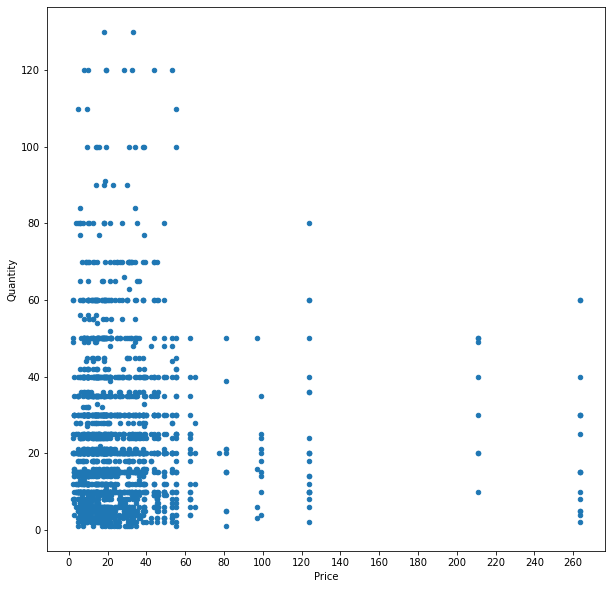

In [5]:
import matplotlib.pyplot as plt
df.plot('Price','Quantity',kind='scatter',figsize=(10,10));
plt.xticks([20*i for i in range(30)]);
plt.plot()

#It appears that high priced items (>$70) do not get order sies over 80, and also are very rarely ordered. 
#It may be useful to see if price is a confounding factor for Discount vs Quantity

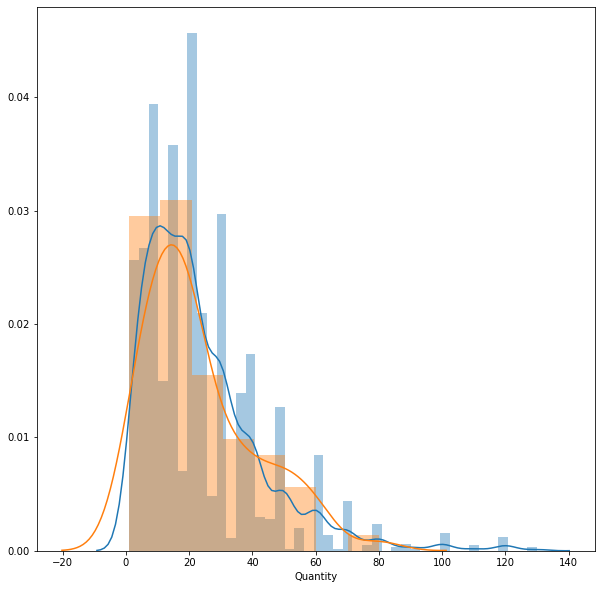

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)





Low=df[df.Price<70].Quantity
High=df[df.Price>70].Quantity

plt.figure(figsize=(10,10))
sns.distplot(Low)
sns.distplot(High)
plt.show()




#Perhaps not. Q1--------Does the quantity per order differ between the low cost and high cost groups?
#Null Hypothesis: The size of the order is independent of the price
#Alternative Hypothesis: Orders of high cost are smaller in size

In [7]:
import scipy.stats as stats

results=stats.ttest_ind(Low,High,equal_var=False)

print(f'The p-value of the t-test between low and high cost groups is {results[1]},meaning we cannot reject H0')

The p-value of the t-test between low and high cost groups is 0.7675564866845941,meaning we cannot reject H0


In [8]:
print(df.Discount.value_counts())
#ignore discount amounts with value_counts in the single digits
#there are too few occurrences to perform meaningful statistics


print(df[((df.Discount<.05)& (df.Discount!=0)) | (df.Discount==.06)])
#also, discounts of a few percent are very unlikely to have a large effect size for such low prices

discounts=[.05,.1,.15,.2,.25]

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64
                            ProductID  Price  Discount  Quantity
OrderID                                                         
11077    Grandma's Boysenberry Spread  25.00      0.02         1
11077                            Tofu  23.25      0.03         1
11077                         Pavlova  17.45      0.03         2
11077          Sir Rodney's Marmalade  81.00      0.04         1
11077                       Spegesild  12.00      0.02         3
11077               Camembert Pierrot  34.00      0.06         2
11077       Wimmers gute Semmelknödel  33.25      0.03         2
11077                      Röd Kaviar  15.00      0.01         2


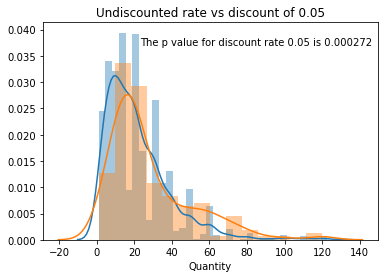

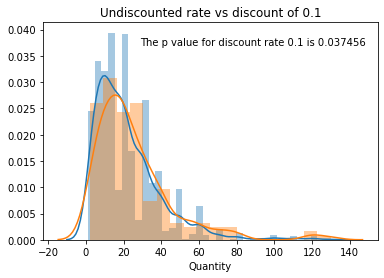

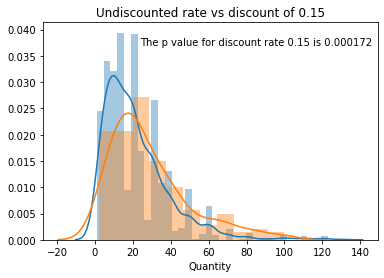

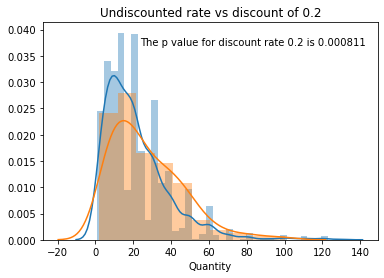

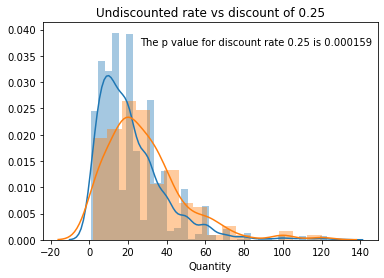

In [9]:
Ctrl=df[df.Discount==0].Quantity

for key,disc in enumerate(discounts):
    Exp=df[df.Discount==disc].Quantity
    sns.distplot(Ctrl)
    sns.distplot(Exp)
    plt.title(f'Undiscounted rate vs discount of {disc}')
    plt.figtext(.35,.8,f'The p value for discount rate {disc} is {round(stats.ttest_ind(Ctrl,Exp,equal_var=False)[1],6)}')
    plt.show()

#The p-vals are all significant for these discount levels, but are the effect sizes worthwhile?


In [10]:
import numpy as np

#Q2-------How large of an effect does each discount level have?
aggs=df.groupby('Discount').agg(['mean','std','count'])['Quantity'].dropna()
aggs.drop([.02,.03],inplace=True)
aggs.head(10)

ES=[]
def cohenD(disc):
    CtrlStd=aggs['std'][0]
    CtrlNum=aggs['count'][0]
    CtrlMean=aggs['mean'][0]
    
    ExpStd=aggs['std'][disc]
    ExpNum=aggs['count'][disc]
    ExpMean=aggs['mean'][disc]
    
    den=CtrlNum+ExpNum-2
    num=(CtrlNum-1)*CtrlStd**2+(ExpNum-1)*ExpStd**2
    
    s=np.sqrt(num/den)
    return (ExpMean-CtrlMean)/s

for disc in discounts:
    ES.append(cohenD(disc))
    print(f'The effect size at discount level {disc} is {cohenD(disc)}')
    

# While statistically significant, all effect sizes are small to moderate. Discounting these products only increases the 
#quantities bought by a small margin 


The effect size at discount level 0.05 is 0.3469259331213803
The effect size at discount level 0.1 is 0.19596431111215432
The effect size at discount level 0.15 is 0.3724449105051497
The effect size at discount level 0.2 is 0.3007245635324173
The effect size at discount level 0.25 is 0.36662317783822485


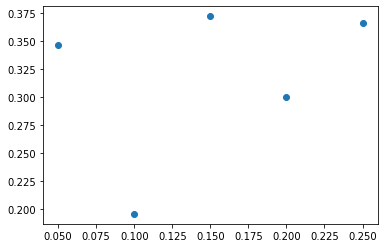

In [11]:
#Q3-------does raising the discount amount to a certain threshold guarantee more sales


plt.scatter(discounts,ES)
plt.show()

#It seems like the effect size has no correlation with discount amount.
#This means discounting by 5% is just as good as by 25%

ProductID
Côte de Blaye              141396.735
Raclette Courdavault        71155.700
Thüringer Rostbratwurst     80368.672
Name: Total, dtype: float64

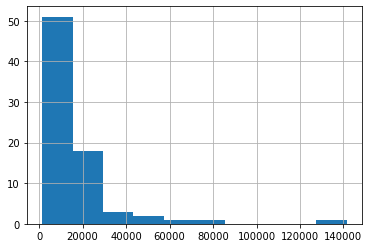

In [12]:
#Question: Do all items net the same profit? Null hypothesis is that each item yields the same total price.

df['Total']=df['Quantity']*df['Price']*(1-df['Discount'])
df.head()

Profits=df.groupby('ProductID').Total.sum()
Profits.hist()

#Looks like they do not, at all. Most items return a net worth of <40k.

Profits[Profits>50000]

#As one might expect, the most profitable items are the most expensive, even though they don't make as many sales

In [13]:
cur.execute("""select * from Employee """)
Emp=pd.DataFrame(cur.fetchall())
Emp.columns=[x[0] for x in cur.description]
Emp.index=Emp.Id


#There are 4 older individuals (born before 1990) and 5 millenials.
BoomerIds=[1,2,4,5]
MillIds=[3,6,7,9]

#Question: Is this age disparity relevant to total sales made? H0: There is no difference between sales based on age

cur.execute(""" select EmployeeId,Quantity from 'Order' join 'OrderDetail' """)
Ord=pd.DataFrame(cur.fetchall())
Ord.columns=[x[0] for x in cur.description]

Emp.BirthDate

Id
1    1980-12-08
2    1984-02-19
3    1995-08-30
4    1969-09-19
5    1987-03-04
6    1995-07-02
7    1992-05-29
8    1990-01-09
9    1998-01-27
Name: BirthDate, dtype: object

In [14]:
import scipy.stats as stats

BoomOrd=Ord[Ord.EmployeeId.isin(BoomerIds)].Quantity
MillOrd=Ord[Ord.EmployeeId.isin(MillIds)].Quantity

results=stats.ttest_ind(BoomOrd,MillOrd,equal_var=False)
print(results)

#Answer: Cannot reject null hypothesis, it seems that age has no effect on work product. Old, experienced employees
#are not necessarily better than younger employees

Ttest_indResult(statistic=0.0, pvalue=1.0)


In [15]:
Emp.TitleOfCourtesy.value_counts()
#Question: We have one PhD employee. Does this individual make more sales than the others? H0: the degree makes no effect


Ms.     4
Mr.     3
Dr.     1
Mrs.    1
Name: TitleOfCourtesy, dtype: int64

In [16]:
Emp.TitleOfCourtesy

PhDId=2

PhDOrd=Ord[Ord.EmployeeId==2]
NotPhdOrd=Ord[Ord.EmployeeId!=2]

print(stats.ttest_ind(PhDOrd,NotPhdOrd,equal_var=False))

#Again, the Phd does not seem to influence sales. This means hiring higher degrees will not likely improve sales

Ttest_indResult(statistic=array([-1372.57338765,     0.        ]), pvalue=array([0., 1.]))
